In [ ]:
import os, sys
dir1 = os.path.abspath('..\..')
sys.path.append(dir1+ "\\")

import MetaTrader5 as mt
from datetime import datetime as dt

# custom
from my_jupyter.user import User
from my_jupyter.strategy_manager import StrategyManager
from my_jupyter.operation import Operation
from my_jupyter.strategies.min_max_strategy import MinMaxStrategy
from my_jupyter.market_data_repository import MarketDataRepository
from my_jupyter.filters.moving_average import MovingAverageFilter
from my_jupyter.filters.consequent_limits_counter import ConsequentLimitsCounterFilter
from my_jupyter.filters.directioned_bars_filter import DirectionedBarsFilter

# from Mbox import Mbox
# from boleta_1 import gerar_boleta
# from gerenciamento import Gerenciamento

## GUI's
from daemon_tools import DaemonThreadMini


In [ ]:


filters = [DirectionedBarsFilter(candles=5), MovingAverageFilter(), MovingAverageFilter(period=200)]
strategies = [MinMaxStrategy(filters=filters)]
operations = [Operation("WINV23", 1, mt.TIMEFRAME_M1, can_buy=True, can_sell=True)]
user = User(strategies=strategies, operations=operations, trading_time_start=dt(2023,10,5,9,5,0))
market_data_repository = MarketDataRepository()
strategy = StrategyManager(market_data_repository, user)

# PARAMETROS MAIN
kwargs = {
    "strategy": strategy,
}


def main(**kwargs):
    _shift = 0
    strategy: StrategyManager = kwargs["strategy"]
    strategy.run_strategies()
    # print(f"{dt.now().strftime('%d/%m/%Y, %H:%M:%S')} >>> D-{_shift}")
def exec_daemon(**kwargs):
    main(**kwargs)
    # alarme.ring_alarme()

In [ ]:
# gerenciamento = Gerenciamento(mt, timeframe, timeframes_dict)

try:
    main(**kwargs)
except Exception as e:
    print(e.with_traceback(__tb=None))
    # Mbox.Alerta("ERRO", "busca de sinais com erro")


In [ ]:
# from my_jupyter.daemons.daemon_tools import DaemonThreadMini


# thread_exec = DaemonThreadMini(exec_daemon, seconds=0, mseconds=800, **kwargs)
# thread_exec.start()

In [1]:
import os, sys

dir1 = os.path.abspath("..\..")

if dir1 not in sys.path:
    sys.path.append(dir1 + "\\")
from my_jupyter.indicator.bars_trend_quality_ml import BarsTrendQualityML
from my_jupyter.market_data_repository import MarketDataRepository
from datetime import datetime as dt 
import pandas as pd 
# mt_rep = MarketDataRepository()
# ohlc = mt_rep.read_data("WINV23",mt_rep.mt.TIMEFRAME_M1,6)
# ohlc = mt_rep.mt.copy_rates_from_pos("WINV23", mt_rep.mt.TIMEFRAME_M1, 0, 99999)
# ohlc_0_based = ohlc[::-1]

# from_file  = "dataset\WINV23M1.csv"
# ohlc_df = pd.DataFrame(ohlc)
bars_trend_ml = BarsTrendQualityML(quantity_of_bars_in_thousands=5)
bars_trend_ml.set_machine_learning_model(from_stock_market_data="WIN$")


c:\repo\python\financial-api\my_jupyter\modules\backtest_for_ml_module.py:29: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  bt = Backtest(


before filter 2153 2049 93525


c:\repo\python\financial-api\my_jupyter\modules\backtest_for_ml_module.py:161: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  curr_min = curr[-1]


after filter 1354 1495 1323
Epoch 1/10
106/106 [==============================] - 1s 6ms/step - loss: 0.8109 - accuracy: 0.6220 - val_loss: 0.4267 - val_accuracy: 0.9096
Epoch 2/10
106/106 [==============================] - 0s 3ms/step - loss: 0.3161 - accuracy: 0.9133 - val_loss: 0.2083 - val_accuracy: 0.9282
Epoch 3/10
106/106 [==============================] - 0s 3ms/step - loss: 0.2163 - accuracy: 0.9180 - val_loss: 0.1733 - val_accuracy: 0.9335
Epoch 4/10
106/106 [==============================] - 0s 3ms/step - loss: 0.1818 - accuracy: 0.9292 - val_loss: 0.1449 - val_accuracy: 0.9415
Epoch 5/10
106/106 [==============================] - 0s 4ms/step - loss: 0.1732 - accuracy: 0.9284 - val_loss: 0.1402 - val_accuracy: 0.9388
Epoch 6/10
106/106 [==============================] - 0s 4ms/step - loss: 0.1599 - accuracy: 0.9340 - val_loss: 0.1357 - val_accuracy: 0.9388
Epoch 7/10
106/106 [==============================] - 1s 5ms/step - loss: 0.1572 - accuracy: 0.9310 - val_loss: 0.1340 -

: 

9 act         1.000000
close-1    11.111111
close-2    13.333333
close-3     8.888889
close-4     4.444444
close-5     0.000000
dtype: float64 act        0.000000
close-1    8.579692
close-2    6.614378
close-3    4.859127
close-4    4.639804
close-5    0.000000
dtype: float64


<Axes: >

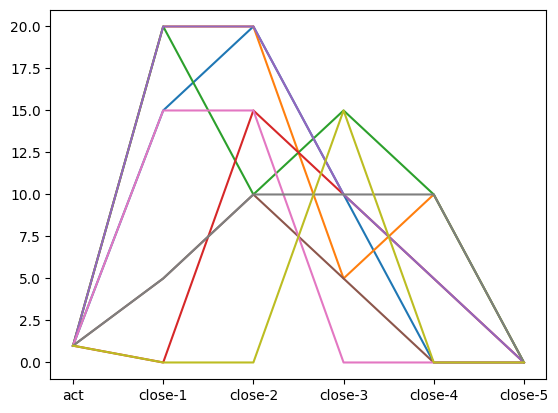

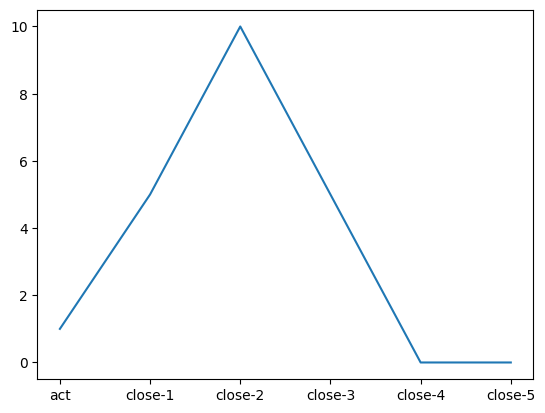

In [20]:
df = bars_trend_ml.df
op = 1
mean, std = df[df["act"] == op].mean(), df[df["act"] == op].std()
print(len(df[df["act"] == op]), mean, std)
df[df["act"] == op].T.plot(legend=False)


for i in df:
    if i == "act":
        continue
    lower_std = mean[i] - std[i]
    upper_std = mean[i] + std[i]
    indexRemove = df[
        (df["act"] == op) & ((df[i] < lower_std) | (df[i] > upper_std))
    ].index
    df.drop(indexRemove, inplace=True)
df[df["act"] == op][0:].T.plot(legend=False)

1/1 - 0s - 90ms/epoch - 90ms/step
1/1 - 0s - 33ms/epoch - 33ms/step
1/1 - 0s - 45ms/epoch - 45ms/step
1/1 - 0s - 39ms/epoch - 39ms/step
1/1 - 0s - 24ms/epoch - 24ms/step
1/1 - 0s - 38ms/epoch - 38ms/step
1/1 - 0s - 28ms/epoch - 28ms/step
1/1 - 0s - 30ms/epoch - 30ms/step
1/1 - 0s - 41ms/epoch - 41ms/step
1/1 - 0s - 34ms/epoch - 34ms/step
1/1 - 0s - 41ms/epoch - 41ms/step
1/1 - 0s - 46ms/epoch - 46ms/step
1/1 - 0s - 40ms/epoch - 40ms/step
1/1 - 0s - 45ms/epoch - 45ms/step
1/1 - 0s - 47ms/epoch - 47ms/step
1/1 - 0s - 47ms/epoch - 47ms/step
1/1 - 0s - 33ms/epoch - 33ms/step
1/1 - 0s - 44ms/epoch - 44ms/step
1/1 - 0s - 50ms/epoch - 50ms/step
1/1 - 0s - 42ms/epoch - 42ms/step
1/1 - 0s - 45ms/epoch - 45ms/step
1/1 - 0s - 43ms/epoch - 43ms/step
1/1 - 0s - 48ms/epoch - 48ms/step
1/1 - 0s - 44ms/epoch - 44ms/step
1/1 - 0s - 49ms/epoch - 49ms/step
1/1 - 0s - 34ms/epoch - 34ms/step
1/1 - 0s - 48ms/epoch - 48ms/step
1/1 - 0s - 48ms/epoch - 48ms/step
1/1 - 0s - 41ms/epoch - 41ms/step
1/1 - 0s - 46m

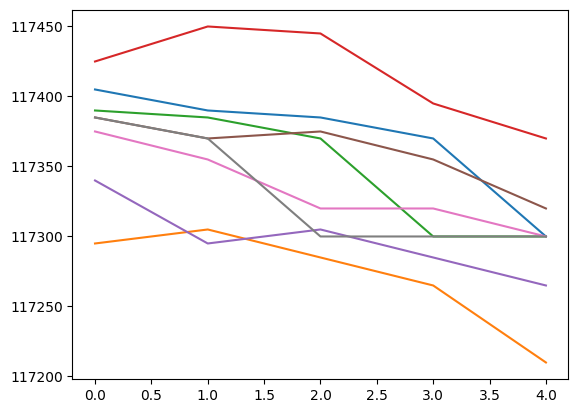

In [5]:
from my_jupyter.market_data_repository import MarketDataRepository
from datetime import datetime as dt

mt_rep = MarketDataRepository()
ohlc = mt_rep.read_data("WINV23", mt_rep.mt.TIMEFRAME_M1, 6)
ohlc = mt_rep.mt.copy_rates_from_pos("WINV23", mt_rep.mt.TIMEFRAME_M1, 0, 60)
ohlc_0_based = ohlc[::-1]
# print([ dt.fromtimestamp(i[0]) for i in ohlc_0_based])
# bars_trend_ml.output(ohlc_0_based[1:])
import numpy as np


to_timestamp = lambda x: dt.fromtimestamp(x)
ohlc_transform = [
    (ohlc_0_based[i : i + 5]["close"],to_timestamp(ohlc_0_based[i]["time"])) for i in range(1, len(ohlc_0_based) - 5)
]
# ohlc_transform = [ i - min(i) for i in ohlc_transform ]
ohlc_transform = [
    (ohlc_transform[i][0] - ohlc_transform[i][0][-1], ohlc_transform[i][1], ohlc_transform[i][0])
    for i in range(len(ohlc_transform))
]

results = []
df = pd.DataFrame()
for i in range(0, len(ohlc_transform)):
    res = np.round(bars_trend_ml.output(ohlc_transform[i][0]) * 100)
    results.append({"out":res[0], "in":ohlc_transform[i][2],"time":ohlc_transform[i][1]})

analyze = 2
res = sorted(results, key=lambda x: -x["out"][analyze])
# print(">>>>>>>>>>", *res,sep="\n")
for i in range(len(res)):
    # if res[i][0][2]> 50:
    if res[i]["out"][analyze] == max(res[i]["out"]):
        print(res[i])
        pd.Series(res[i]["in"]).plot()


{'out': array([ 57., 100.,   0.], dtype=float32), 'in': array([117320., 117300., 117305., 117270., 117325.]), 'time': datetime.datetime(2023, 10, 11, 14, 48)}
{'out': array([  4., 100.,   2.], dtype=float32), 'in': array([117295., 117280., 117295., 117340., 117295.]), 'time': datetime.datetime(2023, 10, 11, 14, 7)}
{'out': array([ 29., 100.,   1.], dtype=float32), 'in': array([117280., 117295., 117340., 117295., 117305.]), 'time': datetime.datetime(2023, 10, 11, 14, 6)}
{'out': array([99., 99.,  0.], dtype=float32), 'in': array([117300., 117305., 117270., 117325., 117350.]), 'time': datetime.datetime(2023, 10, 11, 14, 47)}
{'out': array([90., 99.,  0.], dtype=float32), 'in': array([117305., 117270., 117325., 117350., 117345.]), 'time': datetime.datetime(2023, 10, 11, 14, 46)}
{'out': array([94., 99.,  0.], dtype=float32), 'in': array([117325., 117350., 117345., 117365., 117375.]), 'time': datetime.datetime(2023, 10, 11, 14, 44)}
{'out': array([22., 99.,  1.], dtype=float32), 'in': arra

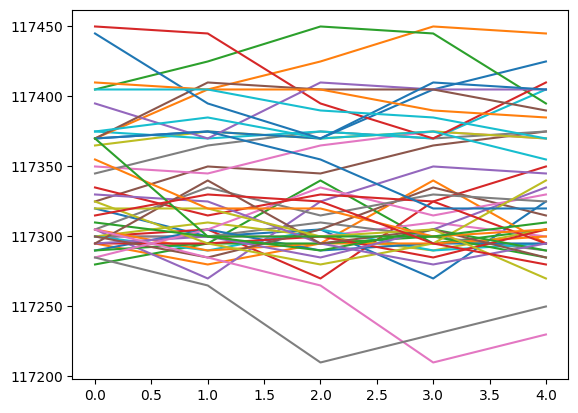

In [8]:
analyze = 1
res = sorted(results, key=lambda x: -x["out"][analyze])
for i in range(len(res)):
    # if res[i][0][2]> 50:
    if res[i]["out"][analyze] == max(res[i]["out"]):
        print(res[i])
        pd.Series(res[i]["in"]).plot()
